<center>
<img src='https://camo.githubusercontent.com/ad20aaaa48264581c46aa126919dbb72060ebd98cffe015523549b4974843ae5/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f46556c79616e6b696e2f725f70726f626162696c6974792f6d61737465722f656e645f73656d696e6172732f73656d5f362f73747564656e745f746561636865725f646973742e706e67' align='center' width="800x">
</center>

# Андан на экономе

## Семинар 11:  гипотетический семинар

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels as sts 

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm
import math

* Возможности `scipy` для проверки гипотез смотрите [в разделе Statistical tests](https://docs.scipy.org/doc/scipy/reference/stats.html)
* Возможности `statsmodels`  [в модуле stats](https://www.statsmodels.org/0.6.1/stats.html)

> Если используете встроенные функции, внимательно читайте документацию и проверяйте как именно расчитываются параметры.

## Упражнение 1 (котики и печеньки)

В этой задачке мы посмотрим на данные одной мобильной игрушки под названием "Cookie Cats", разработанной компанией <a href="http://tactile.dk">Tactile Entertainment</a>. Это стандартный match-three пазл, где игрокам нужно соединять элементы одинаковых цветов, чтобы очистить поле и выиграть на уровне. И еще там есть поющие коты.

<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>

По мере того, как игроки проходят уровни, они встречают ворота-блокеры, которые вынуждают их либо ждать длительное время, либо совершить внутриигровую покупку, чтобы продолжить играть. Помимо того, что эти ворота приносят разработчикам деньги от покупок, они еще и вынуждают игроков делать перерыв, в надежде на то, что те вернутся с новыми силами. 

<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>

Но возникает вопрос - когда и где ставить эти ворота? Изначально первые ворота стояли на 30-м уровне игры, однако в этом ноутбуке мы будем анализировать АБ-тест, в котором разработчики передвинули ворота на 40-й уровень. В частности мы будем смотреть влияние этого изменения на такой важный показатель как "retention" или удержание игроков, который расчитывается как отношение уникальных игроков, зашедших в игру на 1-й, 2-й, ... N-й день после установки ко всем игрокам, установившим приложение в этот день. 

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/hse-econ-data-science/andan_2023/main/sem11_ab/cookie_cats.csv')
print(df.shape)
df.head()

(90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


<ul>
<li><code>userid</code> - уникальный номер, идентифицирующий каждого игрока.</li>
<li><code>version</code> - был ли пользователь отнесен к контрольной группе (<code>gate_30</code> - ворота на 30-м уровне) или к тестовой (<code>gate_40</code> - ворота на 40-м уровне).</li>
<li><code>sum_gamerounds</code> - число сессий, сыгранных игроком в течение первых 14 дней после установки игры.</li>
<li><code>retention_1</code> - вернулся ли игрок после <strong>первого</strong> дня с момента установки?</li>
<li><code>retention_7</code> - вернулся ли игрок после <strong>седьмого</strong> дня с момента установки?</li>
</ul>

Когда игрок устанавливает игру, он/она случайным образом относятся либо к группе gate_30, либо gate_40. На всякий случай, давайте проверим, действительно ли их примерно поровну в каждой из групп.

In [4]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/mr_waffles_smiling.png" style="width:200px; float:left"> </p>
<p>Похоже, что игроков действительно примерно поровну в каждой из групп, отлично!</p>
<p>Фокус нашего анализа будет сосредоточен на удержании игроков (retention), но ради интереса давайте построим распределение числа игровых сессий, сыгранных игроками в течение их первой недели жизни в игре.</p>

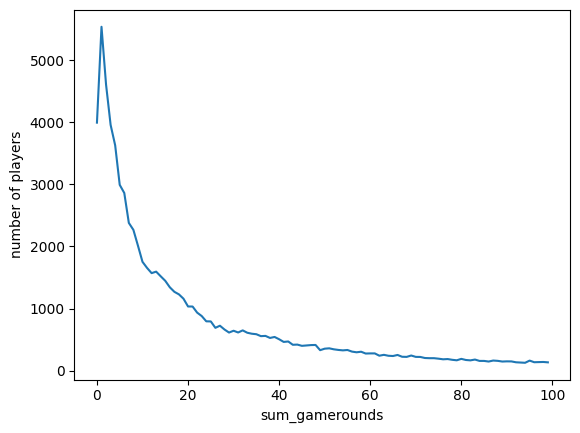

In [5]:
# Считаем число игроков, оставшееся в игре для каждого раунда
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Распределение людей, сыгравших от 0 до 100 раундов
ax = plot_df.head(100).plot()
ax.set_xlabel("sum_gamerounds")
ax.set_ylabel("number of players");

<p>На графике вверху мы видим, что некоторые игроки установили игру, но даже ни разу не поиграли (0 сессий), многие игроки закончили лишь пару сессий за первую неделю, а некоторые действительно подсели и сыграли более 80 раз!</p>
<p>Конечно, мы хотим, чтобы игроки были заинтересованы в игрушке и возвращались в неё снова и снова. Обычная метрика, использующаяся в гейм-индустрии, чтобы измерить, насколько игрушка веселая и захватывающая, - это <em>удержание первого дня</em> (1-day retention): Процент игроков, которые вренулись и снова стали играть спустя 1 день после установки. Чем выше удержание первого дня, тем проще и дальше удерживать пользователей и строить себе большую базу фанатов.</p>
<p>В качестве первого шага, давайте посмотрим, как в целом выглядит 1-day retention.</p>

In [6]:
df.retention_1.mean()

0.4452095044850259

<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/belle_cookie.png" style="width:200px; float:right"> </p>
<p>Итак, немногим меьше половины всех игроков возвращяются к нам спустя один день после установки. Теперь, когда у нас есть это базовое значение (benchmark), давайте посмотрим, как отличается 1-day retention внутри наших тестовых групп.</p>

In [7]:
df.groupby('version').retention_1.mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

<p>Похоже, что у нас есть небольшое ухудшение в удержании первого дня, если мы двигаем ворота к сороковому уровню (44.2%) в сравнеии с контрольной группой, где ворота остались на 30-м уровне (44.8%). Вполне естественен вопрос, а значима ли эта разница? 

__а)__  Постройте примерный $95\%$-й доверительный интервал для каждой из двух долей.

$$
\left[\hat p - z_{crit} \sqrt{\frac{\hat p \cdot (1 - \hat p)}{n}} ; \quad  \hat p + z_{crit} \sqrt{\frac{\hat p \cdot (1 - \hat p)}{n}} \right]
$$

In [8]:
alpha = 0.05
z_crit = stats.norm.ppf(1 - alpha/2) 

df_agg = df.groupby('version').retention_1.agg(['mean', 'count']).reset_index()
df_agg['var'] = df_agg['mean'] * (1 - df_agg['mean'])/df_agg['count']
df_agg['step'] =  z_crit * np.sqrt(df_agg['var'])

df_agg['left'] = df_agg['mean'] - df_agg['step']
df_agg['right'] = df_agg['mean'] + df_agg['step']
df_agg

,version,mean,count,var,step,left,right
0,gate_30,0.448188,44700,0.000006,0.004610,0.443578,0.452798
1,gate_40,0.442283,45489,0.000005,0.004564,0.437719,0.446847


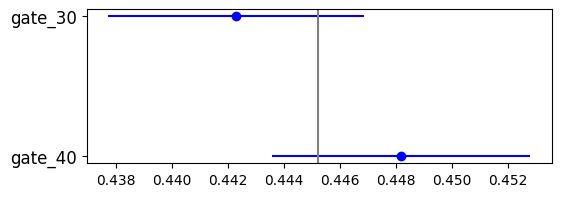

In [9]:
district = ['gate_30', 'gate_40']

center = df_agg['mean'].values
step = df_agg['step'].values

mu_hat = df.retention_1.mean() # общее среднее 

plt.figure(figsize=(6,2))

plt.errorbar(center, np.arange(center.size),  xerr = step, 
             capsize=0, fmt="o", color="blue")

plt.yticks(np.arange(center.size - 1, -1, -1), district, fontsize=12);
plt.axvline(mu_hat, 0, color='grey');

__б)__ Постройте примерный $95\%$-й доверительный интервал для разницы долей.

$$
\left[\hat p_A - \hat p_B - z_{crit} \sqrt{\frac{\hat p_A \cdot (1 - \hat p_A)}{n_A} + \frac{\hat p_B \cdot (1 - \hat p_B)}{n_B}} ; \quad  \hat p_A - \hat p_B + z_{crit} \sqrt{\frac{\hat p_A \cdot (1 - \hat p_A)}{n_A} + \frac{\hat p_B \cdot (1 - \hat p_B)}{n_B}} \right]
$$

In [10]:
x = df[df.version == 'gate_30'].retention_1.values
y = df[df.version == 'gate_40'].retention_1.values

diff = x.mean() - y.mean() 
nx, ny = x.size, y.size
diff_sd = np.sqrt(x.var(ddof=1)/nx + y.var(ddof=1)/nx)

left, right = stats.norm.interval(0.95, loc=diff, scale=diff_sd)
print("Доверительный интервал [{:.4}; {:.4}] ширины {:.4}".format(left, right, right - left))

Доверительный интервал [-0.0006104; 0.01242] ширины 0.01303


Какие выводы можно сделать на основе этих двух пунктов? Обратите внимание, что в пункте __а)__ хочется сделать выводы о влиянии ворот на удержание по пересечению доверительных интервалов. Это очень порочная практика. О ней мы поговорим подробнее в последнем упражнении этой тетрадки. 

__в)__ Проверьте гипотезу о том, что перенос ворот не оказывает никакого влияния на удержание первого дня.

In [11]:
# просто красивая функция для теста гипотез 

def asy_mean_test(mean_hat, std_hat, mu_0=0, 
                   alpha=0.05, alternative='two-sided', margin=3):
    """
        Асимптотический тест для равенства средних
    """
    
    z_obs = (mean_hat - mu_0)/std_hat
    
    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
        z_crit = stats.norm().ppf(1 - alpha/2)
        
        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (z_crit, 0.05, z_crit, margin, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r'), 
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    if alternative == 'less':
        p_value = stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    
    plt.figure(figsize = (8, 4))
    x = np.linspace(-margin, margin)
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]
    
    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        
        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin, 
                 h*y_max, round(statistic, 2), color=color, fontsize=16)
        
        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)
    
    return p_value

In [12]:
alpha = 0.05  
x = df[df.version == 'gate_30'].retention_1.values
y = df[df.version == 'gate_40'].retention_1.values

diff = x.mean() - y.mean() 
nx, ny = x.size, y.size
diff_std = np.sqrt(x.var(ddof=1)/nx + y.var(ddof=1)/nx)
                                    
z_obs = diff/diff_std    
z_crit = stats.norm.ppf(1 - alpha/2) 

print(f'{z_obs:.3} попадает в ({-z_crit:.3} , {z_crit:.3}) => Нулевая гипотеза НЕ отвергается')

1.78 попадает в (-1.96 , 1.96) => Нулевая гипотеза НЕ отвергается


0.07567777112604612

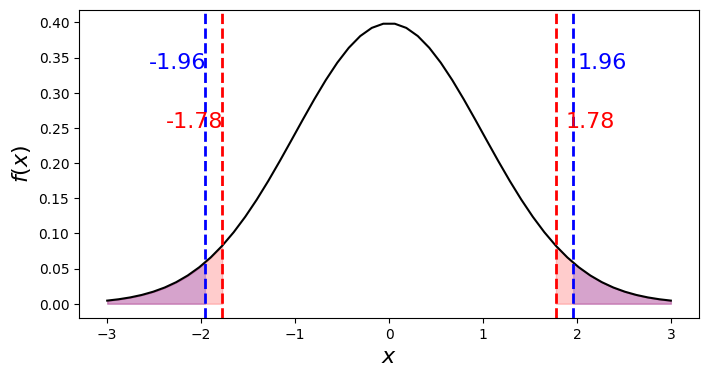

In [13]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05)

__г)__ Проверьте гипотезу о том, что перенос ворот не оказывает никакого влияния на удержание седьмого дня.

0.001629837843281745

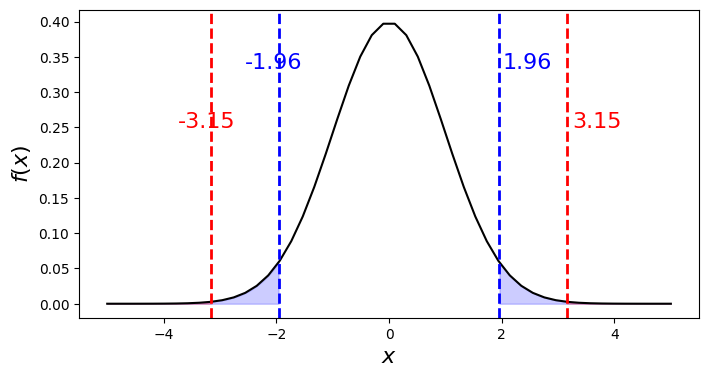

In [14]:
alpha = 0.05  
x = df[df.version == 'gate_30'].retention_7.values
y = df[df.version == 'gate_40'].retention_7.values

diff = x.mean() - y.mean() 
nx, ny = x.size, y.size
diff_std = np.sqrt(x.var(ddof=1)/nx + y.var(ddof=1)/nx)
                                    
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, margin=5)

__д)__ Предположим, что в нашу игру ежедневно играет 100 тысяч человек. Насколько существенный эффект окажет на бизнес перенос ворот на 40 уровень?

In [15]:
df.shape[0] # наверное 5% от всей базы

90189

In [16]:
n = df.shape[0] *100/5
n # всего пользователей

1803780.0

In [17]:
n * diff

14793.337875002122

In [18]:
100*(n * diff) # если каждый за неделю платил нам дополнительные 100 рублей, потери большие

1479333.7875002122

In [19]:
# конечно же, это всё считается по историческим данным :)

<p>Итак, результаты бутстрапа говорят нам о том, что есть значительное доказательство превышения 7-day retentino в группе с воротами на 30-м уровне над группой с воротами на 40-м. Значит, если мы хотим держать ретеншн на высоком уровне и иметь большее число игроков, нам <strong>не нужно</strong> сдвигать ворота с 30-го на 40-й уровень.

<p>Так почему же ретеншн выше, когда ворота расположены раньше? Логично было бы ожидать обратной ситуации - чем позже ставится препятствие, тем дольше игроки будут взаимодействовать с игрой. Однако это не то, что мы видим в данных. Теория гедонистической адаптации может помочь с объяснением. Если вкратце, гедонистическая адаптация - это тенденция получать всё меньше и меньше удовольствия от деятельности, если она продолжается длительное время. Заставляя игроков сделать паузу, когда они достигают 30-го уровня, мы продлеваем им удовольствие от игры, в результате чего они хотят в неё возвращаться. И напротив, сдвигая ворота к 40-му уровню мы даем игрокам возможность наиграться и просто заскучать.</p>

<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_yellow.png" style="width:100px; float:center"> </p>

## Упражнение 2 (ошибки 1 и 2 рода)

Коля Коперник задумал что-то вроде АБ-теста. Он хочет проверить известное утверждение о том, что бутерброд чаще падает маслом вниз. Николай использует асимптотический тест для долей

$$
z = \frac{\hat p - p_0}{\sqrt{\frac{\hat p \cdot (1 - \hat p)}{n}}}
$$

и формулирует свои мысли в виде следующей гипотезы 

$$
\begin{aligned}
&H_0: \hspace{2mm} p = 0.5 \\
&H_1: \hspace{2mm} p > 0.5 
\end{aligned}
$$

Перед проведением АБ-теста обычно фиксируют уровень значимости, $\alpha$. 

- __Ошибка первого рода (уровень значимости)__ - вероятность отвергнуть гипотезу $H_0$, когда она верна. Попробуем с помощью симуляций вычислить её для проверки гипотезы о среднем.

- __Ошибка второго рода__ - вероятность не отвергнуть гипотезу $H_0$, когда она неверна.

__а)__  Пусть Николай зафикисировал $\alpha = 0.05$ и собрал $100$ наблюдений, а настоящее значение $p = 0.5$. 

С помощью симуляций  проверьте гипотезу Коперника $10^4$ раз и убедитесь, что доля ошибок действительно будет $5\%.$

In [20]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

def prop_asy_test(x, p0=0.5):
    p = x.mean()
    z_obs = (p - p0)/np.sqrt(p0*(1-p0)/x.size)
    pval = 1 - stats.norm.cdf(z_obs)  # p-value
    return pval

def get_simulation(n_obs=10**4, n=100, p_real=0.5):
    bern_rv = stats.bernoulli(p=p_real)
    
    res = np.zeros(n_obs)
    for i in range(n_obs):
        x = bern_rv.rvs(n)
        res[i] = prop_asy_test(x)
    return res

In [21]:
res = get_simulation()
np.mean(res < 0.05) 

0.0456

__б)__  Пусть Николай зафикисировал $\alpha = 0.05$ и собрал $100$ наблюдений, а настоящее значение $p = 0.6$. С помощью симуляций вычислите ошибку второго рода для нашего эксперимента. 

In [22]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

res = get_simulation(n_obs=10**4, n=100, p_real=0.6)
np.mean(res > 0.05)

0.3772

__в)__ Пусть Николай собрал не $100$, а $200$ наблюдений. Какой будет ошибка второго рода в таком случае? 

In [23]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

res = get_simulation(n_obs=10**4, n=200, p_real=0.6)
np.mean(res > 0.05)

0.1063

Давайте зафиксируем $\alpha=0.05$, а $p=0.6$. Переберите число наблюдений от 10 до 1000 с шагом 50 и нарисуйте график зависимости ошибки второго рода от числа наблюдений.

In [24]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

sample_size = list(range(10, 1011, 50)) 
beta = []
for n in sample_size:
    res = get_simulation(n_obs=10**4, n=n, p_real=0.6)
    beta.append(np.mean(res > 0.05))

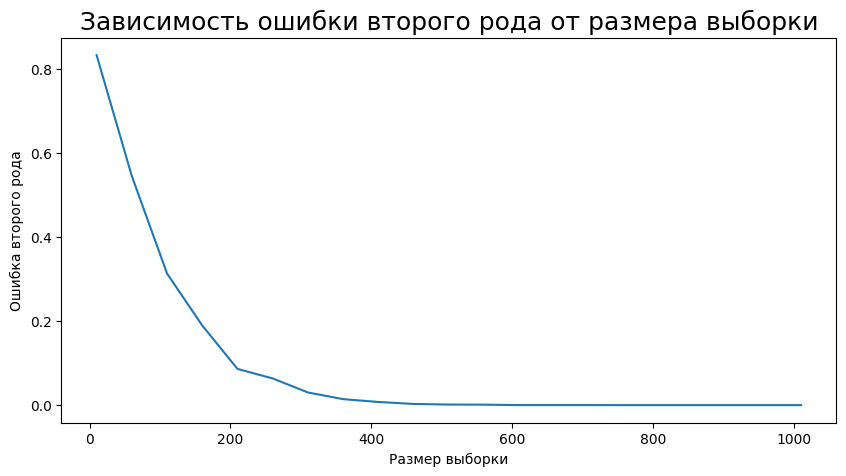

In [25]:
plt.figure(figsize = (10, 5))
plt.plot(sample_size, beta)
plt.title("Зависимость ошибки второго рода от размера выборки", fontsize=18)
plt.ylabel("Ошибка второго рода")
plt.xlabel("Размер выборки");

Объясните, почему нельзя нарисовать такой же график для ошибки первого рода? Что такое презумпция нулевой гипотезы? 

__г)__ Перебирите $\alpha$ в диапазоне $(0; 1)$ с шагом $0.1$. Найдите для каждого значения $\alpha$ значение ошибки второго рода $\beta$. Изобразите на графике получившуюся зависимость для $n = 100$ и $n = 200$. Объясните, что получилось.

In [27]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

res_100 = get_simulation(n_obs=10**4, n=100, p_real=0.6)
res_200 = get_simulation(n_obs=10**4, n=200, p_real=0.6)

In [28]:
alpha = np.linspace(0,1, 1000)[1:-1]
beta_100 = []
beta_200 = []

for a in alpha:
    beta_100.append(np.mean(res_100 > a))
    beta_200.append(np.mean(res_200 > a))

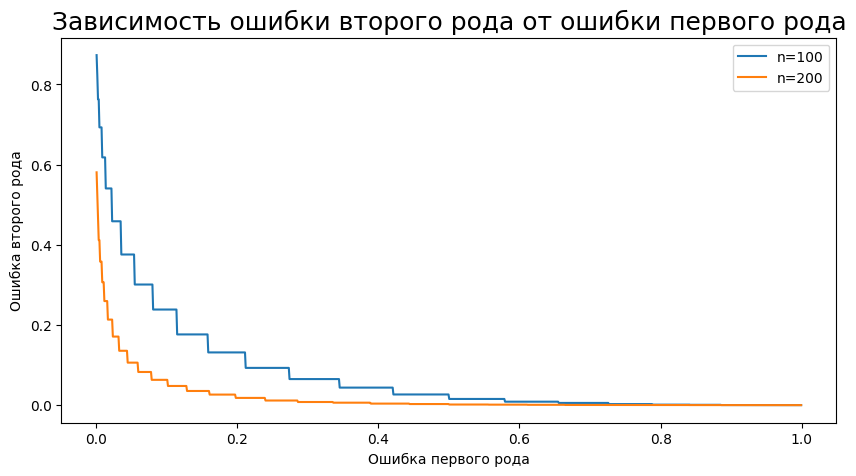

In [29]:
plt.figure(figsize = (10, 5))
plt.plot(alpha, beta_100, label='n=100')
plt.plot(alpha, beta_200, label='n=200')
plt.title("Зависимость ошибки второго рода от ошибки первого рода", fontsize=18)
plt.ylabel("Ошибка второго рода")
plt.xlabel("Ошибка первого рода")
plt.legend();

__MDE (minimal detectable effect) -__ минимальная величина, которую мы хотим поймать нашим АБ-тестом. В случае симуляций выше это была величина $p_a - p_0 = 0.6 - 0.5 = 0.1$. Чем меньше $MDE$, тем сложнее различить две ситуации и тем больше наблюдений нам понадобится.

Ошибку первого рода и MDE обычно фиксируют перед проведением АБ-теста. Ошибку второго рода мы контролируем с помощью числа наблюдений. На самом деле, для критерия рассмотренного выше, можно вывести формулу для поиска числа необходимых наблюдений:

$$
n(\alpha, \beta, MDE)= \frac{\hat{p}_A \cdot (1 - \hat{p}_A) + \hat{p}_B \cdot (1 - \hat{p}_B)}{0.5 \cdot MDE^2 } \cdot (z_{1-\alpha} + z_{1-\beta})^2
$$

Вывод этой формулы можно найти, например, [в лекции Фила.](https://www.youtube.com/watch?v=LTlqyRI8cQ0&list=PLNKXA-74YGLjDOtDSZEFoy1yP-3AfiHUC&index=16) А ещё [прочитайте историю](https://absentis.livejournal.com/27153.html) про то, почему Коперник мазал бутеры маслом. 

На практике, перед запуском эксперимента обычно готовят табличку, в которой смотрят на то, сколько наблюдений понадобится для поиска эффекта разного размера при разных значениях ошибок первого и второго рода. Для разных критериев в интернете можно найти калькуляторы размера выборок.

In [30]:
def get_n_with_p(MDE, alpha, beta, p1=0.010, p2=0.015):
    za = stats.norm().ppf(1 - alpha)
    zb = stats.norm().ppf(1 - beta)
    ans = 1/2 *(p1 * (1-p1) + p2 * (1-p2)) * ((za + zb) / MDE)**2
    return ans 

In [31]:
MDE = 0.01 # Если мы хотим поймать маленькое изменение, надо очень много наблюдений

alphas = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]
betas = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]

Errors = [ ]
for a in alphas:
    cur_error = []
    for b in betas:
        e = get_n_with_p(MDE, a, b)
        cur_error.append(e)
    Errors.append(cur_error)

df_e = pd.DataFrame(Errors)
df_e.columns = alphas
df_e.index = betas
df_e

,0.001,0.010,0.020,0.050,0.100,0.200
0.001,4712.695871,3619.741177,3264.569463,2766.195661,2358.003975,1907.312390
0.010,3619.741177,2670.769902,2366.979953,1945.678203,1605.964771,1238.194987
0.020,3264.569463,2366.979953,2081.526044,1687.728143,1372.451786,1034.273386
0.050,2766.195661,1945.678203,1687.728143,1335.185695,1056.564667,762.772999
0.100,2358.003975,1605.964771,1372.451786,1056.564667,810.511774,556.157565
0.200,1907.312390,1238.194987,1034.273386,762.772999,556.157565,349.559029


https://xkcd.com/1478/

<img src="https://imgs.xkcd.com/comics/p_values_2x.png" height="300" width="300">

## Упражнение 3 (повторное тестирование)

Жизнь исследователя Винни-Пуха прекрасна. Наблюдений много, гипотеза о равенстве математических ожиданий верна, а наблюдения нормальны.

А именно, величины $X_1$, ..., $X_{n}$ независимы и нормальны $N(0;1)$, величины $Y_1$, ..., $Y_n$ независимы и нормальны $N(0;2)$. И пусть $n_x=100$ и $n_y=200$.

Винни-Пух правда этого ничего не знает, потому что у него в голове опилки, и тестирует сначала гипотезу о равенстве дисперсий двух выборок на уровне значимости $5\%$.

__а)__ Проведите $10^6$ экспериментов, то есть $10^6$ раз попробуйте за Винни-Пуха проверить гипотезу. Хорошо бы $10^8$, но оттестируйте сначала свой код на $10^6$. 

Постройте гистограмму распределения тестовой статистики о равенстве дисперсий. В скольки процентах случаев гипотеза о равенстве дисперсий отвергнута? 

100%|██████████████████████████████| 1000000/1000000 [00:18<00:00, 54276.89it/s]


99.8138


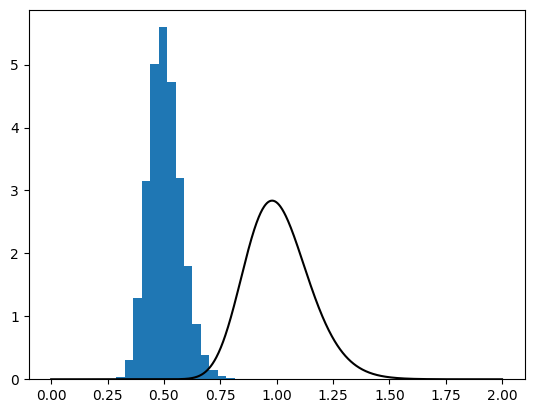

In [32]:
# Код для случая, когда выборки одинакового размера n_x = n_y = 200
# Сделайте симуляцию для выборок разного размера и сравните доли в задании а и б

n = 200
simulations_count = range(int(10**6))
alpha = 0.05
f_distibution = stats.f(n - 1, n - 1)

left_border = f_distibution.ppf(alpha/2)
right_border = f_distibution.ppf(1 - alpha/2)

statistics = []
in_interval = []

for _ in tqdm(simulations_count):
    x = np.random.normal(0, 1, n)
    y = np.random.normal(0, math.sqrt(2), n)
    statistic = x.var() / y.var()
    statistics.append(statistic)
    
    if left_border < statistic < right_border:
        in_interval.append((x, y))
    

xs = np.linspace(0, 2, 1000)
ys = f_distibution.pdf(xs)

plt.figure()
plt.hist(statistics, bins=20, density=True)
plt.plot(xs, ys, color="black")

print(np.mean([left_border > value or value > right_border 
               for value in statistics]) * 100)

__б)__ Если гипотеза о равенстве дисперсий не отвергается, то Винни использует $t$-статистику для проверки гипотезы о равенстве ожиданий при равенстве дисперсий. 

Для тех экспериментов, в которых гипотеза о равенстве дисперсий не отверглась, проверьте гипотезу о равенстве ожиданий на уровне значимости $5\%$. 

Постройте гистограмму распределения $t$-статистики. В скольки процентах случаев гипотеза о равенстве ожиданий отвергнута?

100%|████████████████████████████████████| 1862/1862 [00:00<00:00, 30665.85it/s]

0.054242749731471536


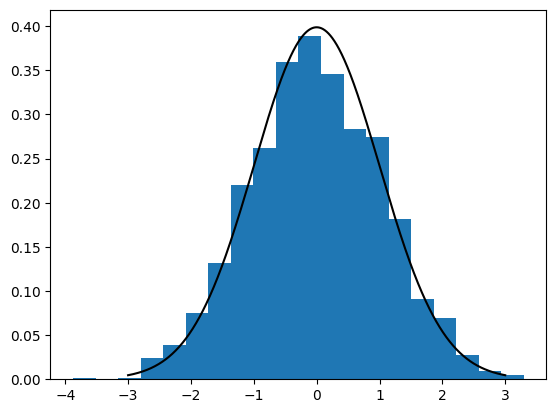

In [33]:
t_distibution = stats.t(2 * n - 2)

alpha = 0.05
left_border = t_distibution.ppf(alpha / 2)
right_border = t_distibution.ppf(1 - alpha/2)

statistics = []

for x, y in tqdm(in_interval):
    sp = math.sqrt(((n - 1) * x.var() + (n - 1) * y.var()) / (2 * n - 2))
    statistics.append((x.mean() - y.mean()) / (sp * math.sqrt(1.0 / n + 1.0 / n)))

xs = np.linspace(-3, 3, 1000)
ys = t_distibution.pdf(xs)

plt.figure()
plt.hist(statistics, bins=20, density=True)
plt.plot(xs, ys, color="black")

print(np.mean([left_border > value or value > right_border 
               for value in statistics]))

# ошибка 1 рода похожа на 0.07, а не на 0.05

__в)__ Словами объясните, почему нехорошо сначала тестировать на равенство дисперсий, а потом на равенство средних при равных дисперсиях, если на первом шаге гипотеза $H_0$ не отверглась. 

In [34]:
'''
Фактическая вероятность ошибки первого рода похожа на 0.06, а не на 0.05.
Ошибка 1 рода - отвергнуть верную гипотезу. 
Это вызвано тем, что t-test мы можем использовать когда дисперсии равны,
а не когда гипотеза о равенстве дисперсий не отвергнута. 

Для двухвыборочных тестов несоблюдение требования равенства дисперсий 
(приводит к увеличению ошибки 1-го рода) допустимо, если:
* распределения соответствуют нормальному;
* выборки отличаются по размеру не больше, чем на 10%
'''


'\nФактическая вероятность ошибки первого рода похожа на 0.06, а не на 0.05.\nОшибка 1 рода - отвергнуть верную гипотезу. \nЭто вызвано тем, что t-test мы можем использовать когда дисперсии равны,\nа не когда гипотеза о равенстве дисперсий не отвергнута. \n\nДля двухвыборочных тестов несоблюдение требования равенства дисперсий \n(приводит к увеличению ошибки 1-го рода) допустимо, если:\n* распределения соответствуют нормальному;\n* выборки отличаются по размеру не больше, чем на 10%\n'

https://xkcd.com/882/
    
![](https://imgs.xkcd.com/comics/significant.png)

## Упражнение 4 (распределение p-value)

С помощью симуляций нарисуйте гистограмму для распределени p-value в случае верности нулевой гипотезы и в случае верности альтернативной гипотезы. Объясните, что означают такие распределения.

In [35]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

## Упражнение 5 (пересечение Vs разность)

Иногда люди делают ужасное. Вместо того, чтобы проверить гипотезу о равенстве средних, они смотрят пересекаются ли доверительные интервалы. Так делать нельзя.

Дело в том, что для одинаковых ошибок первого рода, $\alpha$, ошибка второго рода, $\beta$, для процедуры, основанной на доверительных интервалах, окажется выше. Задание состоит в том, чтобы это увидеть.

### Процедура 1 (правильная):

1. Собираем выборки $X_1, \ldots, X_n$ и $Y_1, \ldots, Y_n$;
2. Находим значение статистики

$$
z_{obs} = \frac{\bar x - \bar y}{\sqrt{\frac{s_x^2}{n_x} + \frac{s_y^2}{n_y}}};
$$

3. Говорим, что по ЦПТ $z_{obs} \overset{asy}{\sim} N(0,1);$
4. Находим критическое значение $z_{1 - \frac{\alpha}{2}}$;
5. Если мы видим, что $|z_{obs}| <  z_{1 - \frac{\alpha}{2}}$, мы говорим, что гипотеза не отвергается. 



### Процедура 2 (мерзкая): 

1. Собираем выборки $X_1, \ldots, X_n$ и $Y_1, \ldots, Y_n$;
2. Находим $\bar x$ и $\bar y$;
3. Пользуясь ЦПТ и зная, что $\bar x \overset{asy}{\sim} N \left(\mu_1,\frac{s^2_x}{n_x} \right)$ и $\bar y \overset{asy}{\sim} N\left(\mu_2,\frac{s^2_y}{n_y}\right)$ строим для $\mu_1$ и $\mu_2$ доверительные интервалы;
4. Если доверительные интервалы пересеклись, говорим, что гипотеза не отвергается. 

Зафиксируйте количество наблюдений, MDE и уровень значимости. Убедитесь с помощью симуляций в том, что ошибка второго рода для второй процедуры будет больше, чем для первой.

Из-за того что мы строим два доверительных интервала вместо одного, ошибка 1 рода выходит из-под контроля. Какой она оказывается на самом деле?

In [36]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

Для этого упражнения можно получить формулы в явном виде. Попробуйте сделать это. Готовый вывод можно найти [в лекции Фила.](https://www.youtube.com/watch?v=6Bcjc_0N_jw&list=PLNKXA-74YGLjDOtDSZEFoy1yP-3AfiHUC&index=17&t=3s)